In [1]:
%load_ext autoreload

This network simulator aims provide a platform for simulating distributed workflows over the WAN. While the simulator must simulate some features such as latency and capacity, it is not intended to model network protocols. In particular, layer 0-3 is highly abstracted and TCP model is simplistic. The focus is on the features and behavior of workflows competing for network resources.

Abstractions are Workflows, Packet, Router, Port, Link, Topology, Endpoint


Workflows
---------

Workflows are sender and receivers of packets over the network. They are responsible for simulating:

  . sending and receiving of data.
  
  . routing. This allow to support simulation of intelligent, dynamic, routing. 
  
  . congestion.
  
  . pacing.
  
  . maintaint statistics, including errors and losses.
  
  
Workflow implementations uses routers and ports to send and receive data. They also implement functions that routers and ports will come back when:

  . a packet is received on a port. This allows the workflow to change the path of the packet if it desires so (not implemented yet). When the last port of the path receives a packet, it delivers it to the workflow.
  
  . a packet is dropped anywhere in the path. This allows the workflow to simulate a particular flow control mechanism.

IMPORTANT: size and time units are not correctly calculated at the moment. This will be fixed soon.

Packet
------

Packets represent a quantity of data expressed as an integer. A packet maintains its own path as a ordered list of router/ports (note, this may/should be changed as a list of links).

Link
----

Links are undirectional, maintain connectivity between two ports, and simulate latency.

Note that timing of the simulation is currently wall clock. That means that latency is expressed in seconds which does not make sense. The overall timing of the simulator needs to allow finer grain timing.

Port
----

Ports are responsible for simulating:
  . ingress / egress of packets
  . capacity limit (i.e. drop packets)
  . buffer (not yet implemented)
  . layer 2 flow control (not yet implemented)

Router
------

Routers are made up ports that are interconnected with a full mesh of links with no latency. 

Endpoint
--------

Endpoints are special types of routers that are used as sources and destinations of workflows. In addition to having a port with a given capacity, the actual rate can statically or dynamically adjusted (rate limiting)


Topology
--------

The set of routers and links constitues the simulated topology which is represented as a graph.

Let's start with a simple topology made of two connected routers. 

Trying this out
--------------
The core of the simulator is the topology:

In [66]:
%aimport simrate
%autoreload 2
from simrate import Topology

topo = Topology("test topology", ticks_per_sec=100)

The new topology object holds the simpy environment, builds the graph representing the network. It also maintains the wall clock time. The value defined by tick_per_sec represents what is the real time value of a simulator tick. In this exemple, 100 ticks per second means that each simulator tick represents 10 ms. 

We can now start creating a simple topology of two routers, interconnected with a 100Gbps link and at a distance of 100ms:

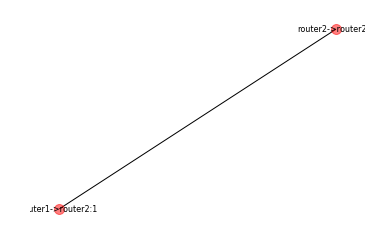

In [67]:
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100) 

topo.draw()

The next step is to create a source and destination of data through the topology. The following will create two servers, each connected to the opposite routers with a 10Gbs link. In this exemple, each of the servers will have a maximum data rate of 8Gbps:

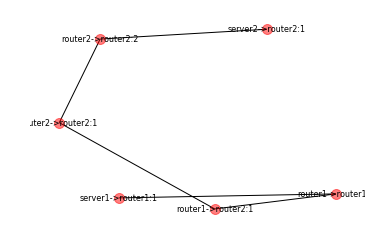

In [68]:
from simrate import Endpoint

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1')
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2')

topo.draw()

We can now create a workflow. It is expected that multiple workflow implementation wil be used.

A default implementation is provided by sim.DataTransfer simulating a file transfer between two endpoints. It simulates the following features:
    - pacing,
    - path computation,
    - routing,
    - dynamic transmit windows.
    
The user can overwrite the simulation of those feature by providing custom implementation.
The following exemple will create a workflow that will simulate the transfer of a 100Gb (all units in the simulator are in bits, not bytes). In addition to the maximum rate of the servers, workflows can also have a maximum rate.

Once the workflow is created, it can be inserted into the topology. Note that a execution time can be provided delaying the begining of the workflow.

In [69]:
from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
flow1.record_drop = True
                     
topo.schedule_workflow(workflow=flow1)

At this point, we have a topology and a workflow to execute. Once all workflows have been created and added, we can run the actual simulation:

In [70]:
topo.start_simulation()

Simulation starts 0
0 start file transfer flow1
time: 126 secs flow1 rtt: 200 average 7936
Simulation stopped simulated elapse time: 126 real time: 0.00718593597412 real/simulate: 17534.2502986


All times are in milliseconds and data size in Mb. Visualizing the flow performance is simple:

In [32]:
flow1.plot_receive()
flow1.plot_rate()
topo.show_plots()

AttributeError: FlowRate instance has no attribute '__float__'

Congestion with large RTT
------------------------

In this exemple, we will add a third server, server3, connected to the same router than server2. Two flows will be created, from server1 to server2 and from server3 to server2, creating a congestion point on the router port connected to server2. The first flow, flow1, is going through a much longer path and therefore has a much higher RTT.

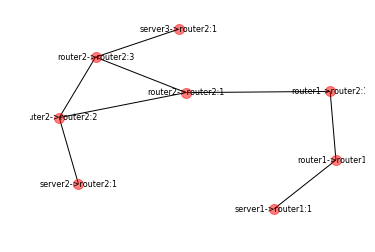

Simulation starts 0
0 start file transfer flow1
0 start file transfer flow2
time: 465 secs flow2 rtt: 60 average 4301
time: 539 secs flow1 rtt: 280 average 3710
Simulation stopped simulated elapse time: 539 real time: 0.392374992371 real/simulate: 1374.39951701


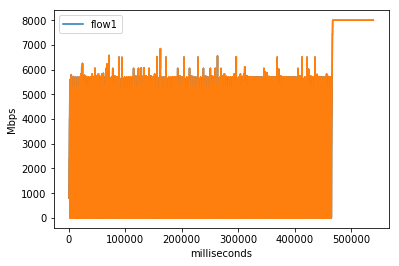

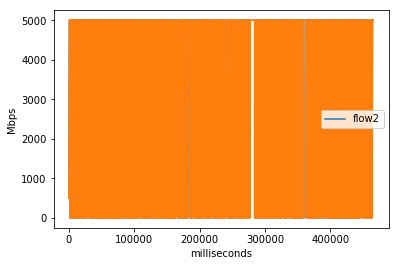

In [44]:
%aimport simrate
%autoreload 1
from simrate import Topology

topo = Topology("test topology", ticks_per_sec=100)

from simrate import Endpoint

topo.add_routers(['router1','router2'])
topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100)

server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=10000)
server1.connect('router1', latency=20)
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=10000)
server2.connect('router2', latency=20)
server3 = Endpoint(name='server3',topology=topo,capacity=10000,rate=10000)
server3.connect('router2', latency=10)

from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=2000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
flow1.record_drop = True

topo.schedule_workflow(workflow=flow1)

flow2 = DataTransfer(name="flow2",
                     src=server3,
                     dst=server2,
                     data_size=2000000,
                     max_rate=5000,
                     topology=topo)

flow2.info = True
flow2.debug = False
flow2.record_receive = True
flow2.record_drop = True

topo.schedule_workflow(workflow=flow2)

topo.draw()

topo.start_simulation()

flow1.plot_receive()
topo.show_plots()
flow2.plot_receive()
topo.show_plots()

In [10]:
%aimport simrate
%autoreload 2
from simrate import Topology, Endpoint

topo = Topology("test topology", ticks_per_sec=100)

topo.debug = False

topo.add_link(router_a='router1',router_b='router2',capacity=10000,latency=100) 
server1 = Endpoint(name='server1',topology=topo,capacity=10000,rate=8000)
server1.connect('router1')
server2 = Endpoint(name='server2',topology=topo,capacity=10000,rate=8000)
server2.connect('router2')
from simrate import DataTransfer

flow1 = DataTransfer(name="flow1",
                     src=server1,
                     dst=server2,
                     data_size=1000000,
                     max_rate=8000,
                     topology=topo)

flow1.info = True
flow1.debug = False
flow1.record_receive = True
flow1.record_drop = True
                     
topo.schedule_workflow(workflow=flow1)


#topo.env.step()
topo.start_simulation()


Simulation starts 0
0 start file transfer flow1
time: 126 secs flow1 rtt: 200 average 7936
Simulation stopped simulated elapse time: 126 real time: 0.0106470584869 real/simulate: 11834.2545178


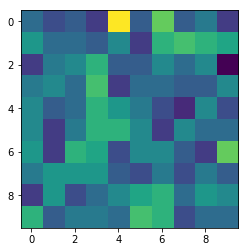

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from random import randint
from time import sleep

from ipywidgets import FloatProgress
from IPython.display import display, clear_output

siz = 10
dat = np.zeros((siz, siz))

fig = plt.figure()
axe = fig.add_subplot(111)
img = axe.imshow(dat)

num = 1000

prgBar = FloatProgress(min=0, max=num-1)
display(prgBar)

for i in range(num):
    clear_output(wait = True)
    prgBar.value = i
    pos = (randint(0, siz-1), randint(0, siz-1))
    dat[pos] += 1
    img.set_data(dat)
    img.autoscale()
    display(fig)

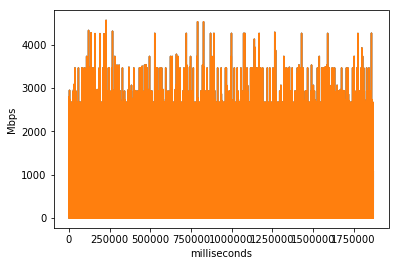

In [26]:

def plot_receive(flow):
    x,y = zip(*flow.receive_data)
    plt.plot(x,y,label=flow.name)
    plt.plot(x,y)
    plt.xlabel('milliseconds')
    plt.ylabel('Mbps')

plot_receive(flow1)
plt.show()


In [29]:
for z in flow1.receive_data:
    if z[1] > 4000:
        print z

[120820, 4333]
[136500, 4279]
[160580, 4258]
[190540, 4258]
[216020, 4256]
[228620, 4566]
[268100, 4316]
[527660, 4266]
[721700, 4266]
[790860, 4533]
[827540, 4532]
[870660, 4266]
[891380, 4266]
[999180, 4266]
[1073940, 4266]
[1080660, 4267]
[1139740, 4132]
[1169420, 4264]
[1265180, 4291]
[1430100, 4266]
[1590260, 4265]
[1776460, 4263]
[1859620, 4270]


In [35]:
print flow1.receive_data[10]

[1260, 2000]


In [33]:
print flow2.receive_data[-1000]

[1648230, 0]
